# Notebook \#2 - Implementation of Fourier Neural Operator

In this beginning notebook, I am going to construct a framework for learning neural operators using the Fourier Neural Operator (FNO) architecture and solve a Diffusion Problem (to be explained later). The structure of this notebook goes as follows:
- Implement a class for the FNO architecture
- Implement a function for training the FNO with given differential equations and initial/boundary conditions
- Generate a training dataset for the input control functions and the corresponding analytical solutions of the differential equation
- Define loss functions associated with physics loss, initial, and boundary conditions
- Train the FNO
- Solve the Feldbaum Problem

Let's start by implementing the Fourier Neural Operator architecture.


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.fft import fft, ifft
from functools import reduce, partial
from datetime import datetime
import operator
from data_fno import MultiFunctionDatasetODE, custom_collate_ODE_fn
import os

## Key Components of the FNO Architecture

### 1. Input Lifting with an MLP

- **Purpose:**  
  The first step is to "lift" the input data—typically low-dimensional features (e.g., time `t` and a function `u`)—into a higher-dimensional feature space. This is done using a Multi-Layer Perceptron (MLP).

- **Implementation:**  
  An MLP is built using a list of layer sizes (e.g., `[2, n_hid, n_hid]`) and corresponding activation functions (e.g., `['tanh', 'tanh']`). This network transforms the concatenated input `(t, u)` into a lifted representation suitable for spectral processing.

---

### 2. Spectral Convolution with Fourier Layers

- **Fourier Transform:**  
  The FNO converts the lifted input into the frequency domain using the Fast Fourier Transform (FFT). For example, in the code:

```python
  x_ft = fft(x, dim=-1)
```
#### Learnable Spectral Filtering:
In the frequency domain, a subset of the Fourier modes (specifically the lower modes, which capture the most significant features) is filtered using learnable weights. This is achieved via an efficient tensor contraction with torch.einsum:
out_ft[:, :, :self.modes] = torch.einsum("bcm,cio->bio", x_ft[:, :, :self.modes], self.weights)
Here:
```python
x_ft[:, :, :self.modes] represents the selected Fourier modes.
```
`self.weights` are learnable parameters with shape `(in_channels, out_channels, modes)`.
#### Inverse Fourier Transform:
After applying the spectral filter, the data is transformed back to the spatial domain using the inverse FFT:
```python
x_out = ifft(out_ft, dim=-1)
return x_out.real
```
Only the real part of the inverse transform is used.
#### Stacking Layers:
Multiple Fourier layers can be stacked to enhance the model’s capacity. An optional nonlinearity (such as tanh) can be applied after each Fourier layer.

### 3. Output Projection with an MLP
***Purpose:***
After spectral convolution, the data is still in a high-dimensional space. An output MLP projects this representation back to the desired output dimension (typically a scalar per input point).
***Implementation:***
Similar to the input MLP, the output MLP is built using a list of layer sizes (e.g., `[n_hid, n_hid, 1]`) and corresponding activation functions (e.g., `['tanh', None]`).


In [5]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        B, C, N = x.shape
        x_ft = torch.fft.rfft(x, dim=-1)  # shape [B, C, N//2 + 1]
        out_ft = torch.zeros(B, self.out_channels, x_ft.size(-1), dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        x = torch.fft.irfft(out_ft, n=N, dim=-1)  # Return to physical space
        return x


# -------------------------
# Simple Block with GELU
# -------------------------
class SimpleBlock1d(nn.Module):
    def __init__(self, modes, width):
        super(SimpleBlock1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)

        x = F.gelu(self.conv0(x) + self.w0(x))
        x = F.gelu(self.conv1(x) + self.w1(x))
        x = F.gelu(self.conv2(x) + self.w2(x))
        x = self.conv3(x) + self.w3(x)

        x = x.permute(0, 2, 1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

# -------------------------
# Wrapper Model
# -------------------------
class Net1d(nn.Module):
    def __init__(self, modes, width):
        super(Net1d, self).__init__()
        self.conv1 = SimpleBlock1d(modes, width)

    def forward(self, u, t):
        x = torch.cat([u.unsqueeze(-1), t], dim=-1)
        return self.conv1(x)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# -------------------------
# Physics-Informed Loss Function
# -------------------------
def compute_loss(model, u, t, dt=1/200, lambda_phys=1.0, lambda_init=10.0):
    x = model(u, t)
    dx_dt = (x[:, 1:, :] - x[:, :-1, :]) / dt
    residual = dx_dt + x[:, :-1, :] - u[:, :-1].unsqueeze(-1)
    physics_loss = torch.mean(residual ** 2)
    initial_loss = torch.mean((x[:, 0, :] - 1.0) ** 2)
    return lambda_phys * physics_loss + lambda_init * initial_loss

# -------------------------
# Training Function
# -------------------------
def train(model, dataloader, optimizer, scheduler, t_grid, num_epochs=1000):
    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        for u, _, _, _ in dataloader:
            u = u.to(device)
            t = t_grid[:u.shape[0], :].to(device)
            loss = compute_loss(model, u, t)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.6f}, Time: {datetime.now().time()}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}, Time: {datetime.now().time()}')

        
        timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
        os.makedirs("trained_models/fno", exist_ok=True)
        torch.save(model.state_dict(), f"trained_models/fno/model_epoch{epoch+1}_{timestamp}_loss{avg_loss:.4f}.pth")

        scheduler.step(avg_loss)

    return model

In [7]:
# -------------------------
# Hyperparameters and Setup
# -------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_functions = 1000000
grfs = ['grf', 'linear', 'sine', 'polynomial', 'constant']
end_time = 1.0
m = 200
batch_size = 1024
num_epochs = 1000

# Time grid
t_grid = torch.linspace(0, end_time, m).unsqueeze(0).repeat(batch_size, 1).unsqueeze(-1)

# Dataset and Dataloader
dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=grfs,
    end_time=end_time,
    num_domain=m,
    num_initial=20,
    grf_lb=0.02,
    grf_ub=0.5
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn, shuffle=True)

In [ ]:
# Model and optimizer
model = Net1d(modes=16, width=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Train
trained_model = train(model, dataloader, optimizer, scheduler, t_grid=t_grid, num_epochs=num_epochs)

In [67]:
# Model setup
model =  Net1d(modes=16, width=64).to(device)

model.load_state_dict(torch.load('trained_models/fno/model_epoch10_20250421-212647_loss0.0013.pth'))
model.eval()  #

def objective_function(args):
    x = args['x']  # shape: [B, m, 1]
    u = args['u']  # shape: [B, m]
    t = args['t']  # shape: [B, m, 1]

    dt = (t[0, 1] - t[0, 0]).item()

    dx_dt = (x[:, 1:, :] - x[:, :-1, :]) / dt
    residual = dx_dt + x[:, :-1, :] - u[:, :-1].unsqueeze(-1)

    physics_loss = torch.mean(residual ** 2)
    initial_loss = torch.mean((x[:, 0, :] - 1.0)**2)
    control_cost = torch.mean(torch.trapz((x**2 + u.unsqueeze(-1)**2), t, dim=1))

    J = 5*control_cost + physics_loss + 5*initial_loss
    return J



# ------------------------
# Gradient Descent Routine (Batched Version)
# ------------------------
def gradient_descent(alpha, m, num_epochs, model, objective_function):  
    u = (0.2 * torch.randn(1, m, device=device))  # shape: [1, m]
    t = torch.linspace(0, end_time, m, device=device).unsqueeze(0).unsqueeze(-1)  # shape: [1, m, 1]

    u.requires_grad_(True)

    optimizer = torch.optim.Adam([u], lr=alpha)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x = model(u, t)  # x: [1, m, 1]

        args = {'u': u, 't': t, 'x': x}
        loss = objective_function(args)

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, time: {datetime.now().time()}')

    return u.detach(), x.detach(), t


In [68]:
# Hyperparameters
n = 1
m = 200
num_epochs = 1500
alpha = 0.001

# Run gradient descent
u_opt, x_opt, t_opt = gradient_descent(alpha, m, num_epochs, model, objective_function)

# Optional: visualize or print results
print("Final optimized control (u):", u_opt)


Epoch [100/1500], Loss: 2.1386, time: 21:27:30.139803
Epoch [200/1500], Loss: 2.0384, time: 21:27:31.325548
Epoch [300/1500], Loss: 1.9839, time: 21:27:32.522912
Epoch [400/1500], Loss: 1.9535, time: 21:27:33.713582
Epoch [500/1500], Loss: 1.9363, time: 21:27:34.899040
Epoch [600/1500], Loss: 1.9264, time: 21:27:36.095272
Epoch [700/1500], Loss: 1.9207, time: 21:27:37.289749
Epoch [800/1500], Loss: 1.9175, time: 21:27:38.494084
Epoch [900/1500], Loss: 1.9157, time: 21:27:39.667358
Epoch [1000/1500], Loss: 1.9146, time: 21:27:40.859510
Epoch [1100/1500], Loss: 1.9141, time: 21:27:42.079546
Epoch [1200/1500], Loss: 1.9137, time: 21:27:43.265074
Epoch [1300/1500], Loss: 1.9136, time: 21:27:44.467511
Epoch [1400/1500], Loss: 1.9135, time: 21:27:45.653175
Epoch [1500/1500], Loss: 1.9134, time: 21:27:46.825879
Final optimized control (u): tensor([[-0.7007, -0.3816, -0.3693, -0.3687, -0.3676, -0.3684, -0.3669, -0.3695,
         -0.3687, -0.3667, -0.3633, -0.3591, -0.3539, -0.3485, -0.3430, -0

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define analytical solutions using NumPy (if not defined yet)
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Create a time grid for plotting. Here t_plot is a NumPy array of shape (m,)
t_plot = np.linspace(0, end_time, m)

# Compute analytical solutions.
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)


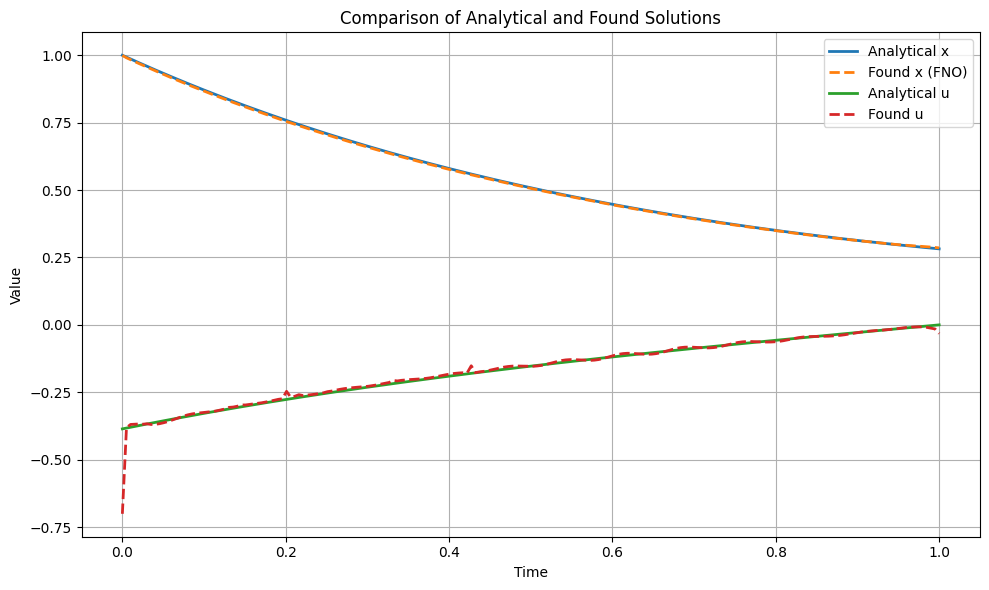

In [70]:
# Detach and move to CPU
x_found = x_opt.squeeze().cpu().numpy()  # shape: (m,)
u_found = u_opt.squeeze().cpu().numpy()  # shape: (m,)

# Make sure t_plot is 1D numpy array of shape (m,)
t_plot = t_opt.squeeze().cpu().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x", linewidth=2)
plt.plot(t_plot, x_found, label="Found x (FNO)", linestyle='--', linewidth=2)
plt.plot(t_plot, analytical_u_vals, label="Analytical u", linewidth=2)
plt.plot(t_plot, u_found, label="Found u", linestyle='--', linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Comparison of Analytical and Found Solutions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
